In [2]:
import os
import cv2
import numpy as np
import configparser
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D,Input,MaxPooling2D,Dropout, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import split_dataset

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

tf.config.run_functions_eagerly(True)
tf.keras.config.enable_interactive_logging()

1 Physical GPU, 1 Logical GPUs



# Iris tracker using CNN
## Load data
Load images of iris from CASIA-Iris-Degradation-Database

/home/davide/Scrivania/IUM/venv/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Example of image:
Shape of images: (75, 100, 1)
Example of label: [344. 222. 139.]
Shape of labels: (3,)


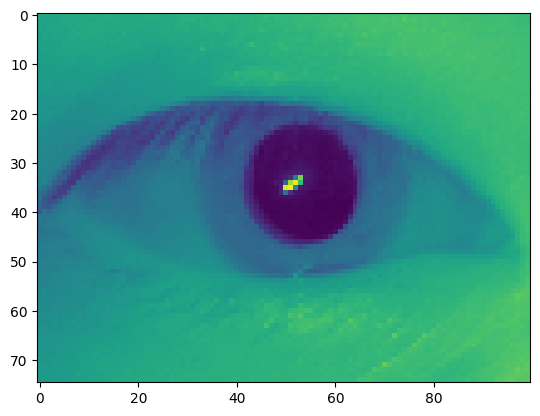

In [3]:
def parse_ini_file(file_path):
    file_path = file_path.numpy().decode('utf-8')
    
    # check if file exists
    if not os.path.exists(file_path):
        return [[0., 0., 0]]
    
    config = configparser.ConfigParser()
    config.read(file_path)
    return [[float(config['iris']['center_x']), float(config['iris']['center_y']), float(config['iris']['radius'])]]

def get_corr_ini_file(image_path):
    return image_path.numpy().decode('utf-8').replace('image', 'localization parameter').replace('.png', '.ini')

data = tf.data.Dataset.list_files('./dataset/CASIA-Iris-Degradation-Database/image/*.png', shuffle=False)

# foreach image, decode the image and find corresponding ini file with the same name and load the image and the ini file
labels = data.map(lambda x: tf.py_function(get_corr_ini_file, [x], tf.string), num_parallel_calls=tf.data.experimental.AUTOTUNE)
data = data.map(lambda x: tf.io.decode_png(tf.io.read_file(x), channels=1), num_parallel_calls=tf.data.experimental.AUTOTUNE)

initial_shape = data.as_numpy_iterator().next().shape

# rescale the image and the ini file
labels = labels.map(lambda x: tf.py_function(parse_ini_file, [x], [tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
data = data.map(lambda x: tf.image.resize(x, [100, 100], preserve_aspect_ratio=True) / 255, num_parallel_calls=tf.data.experimental.AUTOTUNE)

new_shape = data.as_numpy_iterator().next().shape

# set shape of labels
labels = labels.map(lambda x: tf.ensure_shape(x, [3]), num_parallel_calls=tf.data.experimental.AUTOTUNE)

# set 3 channels for the image
# data = data.map(lambda x: tf.tile(x, [1, 1, 3]))

print("Example of image:")
plt.imshow(data.as_numpy_iterator().next())

print("Shape of images: " + str(data.as_numpy_iterator().next().shape))
print("Example of label: " + str(labels.as_numpy_iterator().next()))
print("Shape of labels: " + str(labels.as_numpy_iterator().next().shape))

Link toghether images and labels having same name

In [4]:
dataset = tf.data.Dataset.zip((data, labels))

## Data augmentation

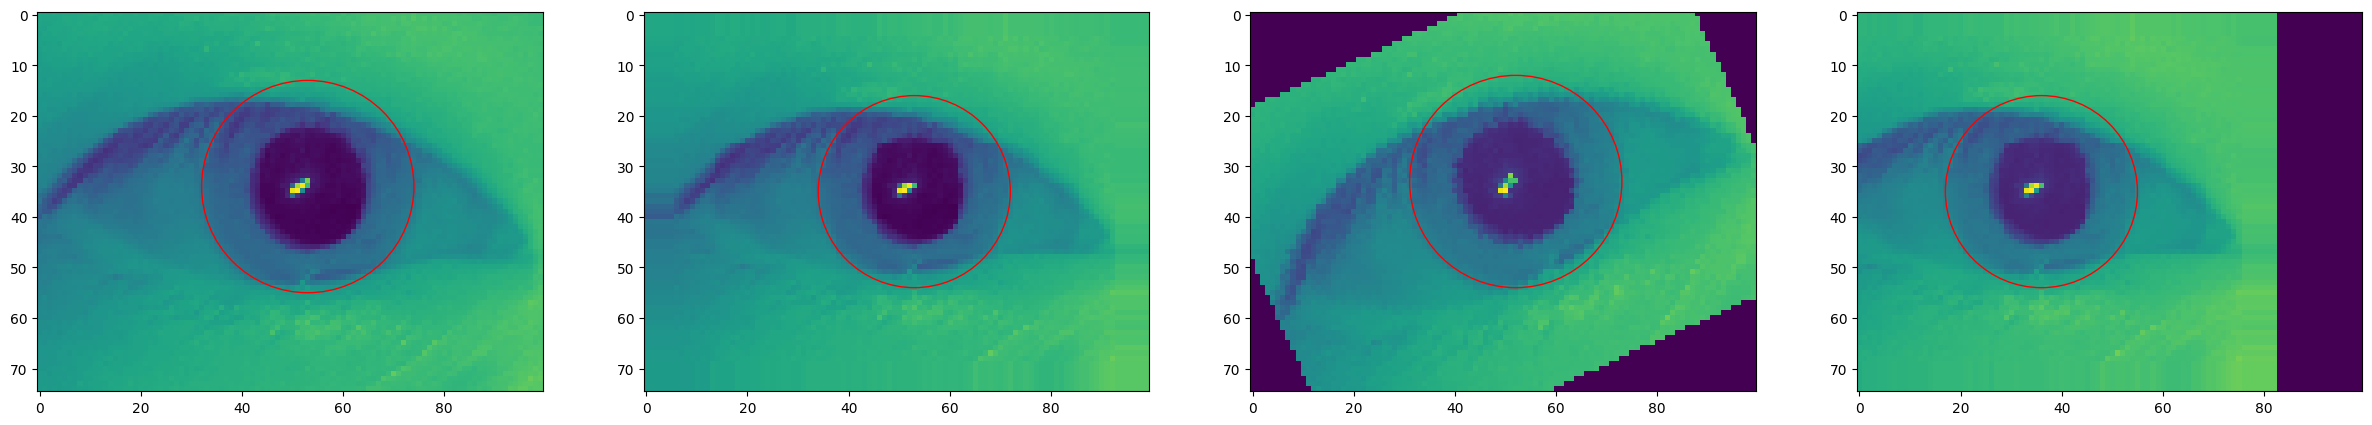

In [5]:
# random zoom, fill mode is border replicate 
def random_zoom_out(image, landmarks, zoom_range=(0.5, 0.9), shape=(96, 96)):
    if type(image) != np.ndarray:
        image = image.numpy()
        
    if type(landmarks) != np.ndarray:
        landmarks = landmarks.numpy()
        
    if type(shape) != tuple:
        shape = shape.numpy()
        
    if type(zoom_range) != tuple:
        zoom_range = zoom_range.numpy()
    
    zoom = np.random.uniform(zoom_range[0], zoom_range[1])
    new_size = (int(image.shape[1] * zoom), int(image.shape[0] * zoom))
    diff_x = shape[0] - new_size[1]
    diff_y = shape[1] - new_size[0]

    image_zoomed = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

    diff_1 = diff_x // 2
    diff_2 = diff_y // 2
    diff_3 = diff_1 + diff_x % 2
    diff_4 = diff_2 + diff_y % 2
    
    image_zoomed = cv2.copyMakeBorder(image_zoomed, diff_1, diff_3, diff_2, diff_4, cv2.BORDER_REPLICATE)
    
    landmarks_zoomed = np.copy(landmarks)
    landmarks_zoomed[0] = landmarks[0] * (initial_shape[0] * zoom) / initial_shape[0] + (initial_shape[1] - initial_shape[1] * zoom) / 2
    landmarks_zoomed[1] = landmarks[1] * (initial_shape[0] * zoom) / initial_shape[0] + (initial_shape[0] - initial_shape[0] * zoom) / 2
    landmarks_zoomed[2] = landmarks[2] * zoom

    if image_zoomed.shape[0] != shape[0] or image_zoomed.shape[1] != shape[1]:
        print('image_zoomed shape:', image_zoomed.shape)
        raise Exception('Invalid shape')

    return np.expand_dims(image_zoomed, axis=2), landmarks_zoomed

# random rotation
def random_rotation(image, landmarks, angle_range=(-30, 30)):
    if type(image) != np.ndarray:
        image = image.numpy()
        
    if type(landmarks) != np.ndarray:
        landmarks = landmarks.numpy()
        
    if type(angle_range) != tuple:
        angle_range = angle_range.numpy()
            
    angle = np.random.uniform(angle_range[0], angle_range[1])
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)

    image_rotated = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)

    landmarks_rotated = np.copy(landmarks)
    x = landmarks[0]
    y = landmarks[1]

    center = (initial_shape[1] // 2, initial_shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    landmarks_rotated[0] = rot_mat[0, 0] * x + rot_mat[0, 1] * y + rot_mat[0, 2]
    landmarks_rotated[1] = rot_mat[1, 0] * x + rot_mat[1, 1] * y + rot_mat[1, 2]

    return np.expand_dims(image_rotated, axis=2), landmarks_rotated

# random shift, choose a random shift value and a random direction
def random_shift(image, landmarks, shift_range=(0, 30)):
    if type(image) != np.ndarray:
        image = image.numpy()
        
    if type(landmarks) != np.ndarray:
        landmarks = landmarks.numpy()
        
    if type(shift_range) != tuple:
        shift_range = shift_range.numpy()
    
    shift = int(np.random.uniform(shift_range[0], shift_range[1]))
    direction = np.random.choice(['left', 'right', 'up', 'down'])

    if direction == 'left':
        shift_x = -shift
        shift_y = 0
    elif direction == 'right':
        shift_x = shift
        shift_y = 0
    elif direction == 'up':
        shift_x = 0
        shift_y = -shift
    else:
        shift_x = 0
        shift_y = shift

    shift_mat = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    image_shifted = cv2.warpAffine(image, shift_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)

    landmarks_shifted = np.copy(landmarks)
    landmarks_shifted[0] += shift_x * initial_shape[0] / image.shape[0]
    landmarks_shifted[1] += shift_y * initial_shape[1] / image.shape[1]

    return np.expand_dims(image_shifted, axis=2), landmarks_shifted

# example of data augmentation
image, iris_coords = dataset.as_numpy_iterator().next()

image_zoomed, coord_zoomed = random_zoom_out(image, iris_coords, shape=(new_shape[0], new_shape[1]))
image_rotated, coord_rotated = random_rotation(image, iris_coords)
image_shifted, coord_shifted = random_shift(image_zoomed, coord_zoomed)

fig, ax = plt.subplots(ncols=4, figsize=(30,30))
ax[0].imshow(image)
ax[1].imshow(image_zoomed)
ax[2].imshow(image_rotated)
ax[3].imshow(image_shifted)

circle = plt.Circle((int(iris_coords[0] * image.shape[0] / initial_shape[0]), int(iris_coords[1] * image.shape[1] / initial_shape[1])), int(iris_coords[2] * image.shape[0] / initial_shape[0]), color='r', fill=False)

circle_zoomed = plt.Circle((int(coord_zoomed[0] * image_zoomed.shape[0] / initial_shape[0]), int(coord_zoomed[1] * image_zoomed.shape[1] / initial_shape[1])), int(coord_zoomed[2] * image_zoomed.shape[0] / initial_shape[0]), color='r', fill=False)

circle_rotated = plt.Circle((int(coord_rotated[0] * image_rotated.shape[0] / initial_shape[0]), int(coord_rotated[1] * image_rotated.shape[1] / initial_shape[1])), int(coord_rotated[2] * image_rotated.shape[0] / initial_shape[0]), color='r', fill=False)

circle_shifted = plt.Circle((int(coord_shifted[0] * image_shifted.shape[0] / initial_shape[0]), int(coord_shifted[1] * image_shifted.shape[1] / initial_shape[1])), int(coord_shifted[2] * image_shifted.shape[0] / initial_shape[0]), color='r', fill=False)
                            
ax[0].add_artist(circle)
ax[1].add_artist(circle_zoomed)
ax[2].add_artist(circle_rotated)
ax[3].add_artist(circle_shifted)

Apply data augmentation to the dataset

In [6]:
# choose a random subset of the dataset and apply data augmentation
def augment_dataset(dataset, size=1000):
    augmented_dataset = tf.data.Dataset.sample_from_datasets([dataset]).take(size)
    augmented_dataset_1 = augmented_dataset.map(lambda x, y: tf.py_function(random_zoom_out, [x, y, (0.5, 0.9), (new_shape[0], new_shape[1])], [tf.float32, tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    augmented_dataset_2 = augmented_dataset.map(lambda x, y: tf.py_function(random_rotation, [x, y], [tf.float32, tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    augmented_dataset_3 = augmented_dataset_1.map(lambda x, y: tf.py_function(random_rotation, [x, y], [tf.float32, tf.float16]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return augmented_dataset_1.concatenate(augmented_dataset_2).concatenate(augmented_dataset_3)

augmented_dataset = augment_dataset(dataset, 10000)
dataset = dataset.concatenate(augmented_dataset)

In [7]:
# ensure shape of the dataset
dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, [new_shape[0], new_shape[1], 1]), tf.ensure_shape(y, [3])), num_parallel_calls=tf.data.experimental.AUTOTUNE)

## Divide dataset into train, test and validation

In [8]:
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
val_size = len(dataset) - train_size - test_size

# use tf.keras.utils.split_dataset to split the dataset into train, test and validation
train_dataset, test_val_dataset = split_dataset(dataset, train_size, test_size + val_size, shuffle=True, seed=42)
test_dataset = test_val_dataset.take(test_size)
val_dataset = test_val_dataset.skip(test_size)

print("Train size: " + str(len(train_dataset)))
print("Test size: " + str(len(test_dataset)))
print("Validation size: " + str(len(val_dataset)))

Train size: 46577
Test size: 9980
Validation size: 9982


## Shuffle, batch and prefetch the datasets

In [9]:
train_dataset = train_dataset.shuffle(1000).batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(1000).batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(1000).batch(64, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False).prefetch(tf.data.AUTOTUNE)

## Show some examples

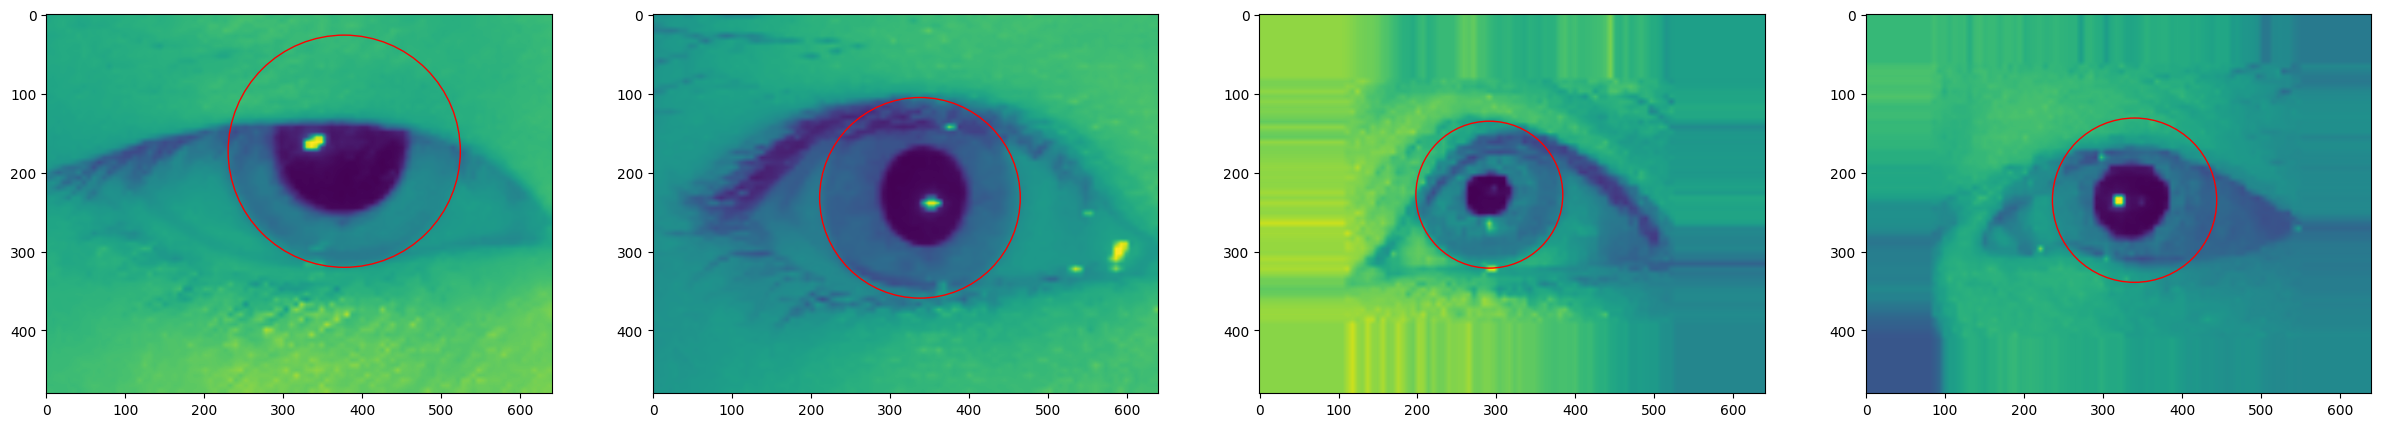

In [10]:
res = train_dataset.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(30,30))
for idx in range(4):
    image = np.copy(res[0][idx])
    iris_coords = res[1][idx]
    
    image = cv2.resize(image, (initial_shape[1], initial_shape[0]))

    circle = plt.Circle((int(iris_coords[0]), int(iris_coords[1])), int(iris_coords[2]), color='r', fill=False)

    ax[idx].imshow(image)
    ax[idx].add_artist(circle)

# Create the model

In [10]:
model = Sequential([
    Input(shape=new_shape),
    
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(1024, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    BatchNormalization(),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(128, 2, 2, activation='relu'),
    Dropout(0.15),
    
    Conv2D(3, 1, 1),
    Reshape((3,)),
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 75, 100, 1)     │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 75, 100, 128)   │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 37, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 25, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 9, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 12, 1024)    │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 6, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 6, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 3, 256)      │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 1, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 3)        │           387 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,052,807 (42.16 MB)

 Trainable params: 11,049,989 (42.15 MB)

 Non-trainable params: 2,818 (11.01 KB)

## Losses and optimizer

In [11]:
# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['accuracy', 'mae'])

In [12]:
X, y = train_dataset.as_numpy_iterator().next()
X.shape

(64, 75, 100, 1)

In [13]:
scores = model.predict(X)
scores

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


array([[ 0.0059069 , -0.0102849 ,  0.00737977],
       [ 0.00461576, -0.0087854 ,  0.00494406],
       [ 0.00573298, -0.01389309,  0.00747913],
       [ 0.00478318, -0.01034204,  0.00610514],
       [ 0.00616742, -0.0112021 ,  0.00673303],
       [ 0.00508907, -0.01304093,  0.00907592],
       [ 0.00686794, -0.01191331,  0.00732299],
       [ 0.00496886, -0.00994242,  0.00659513],
       [ 0.00598312, -0.01127071,  0.0077187 ],
       [ 0.00401637, -0.01072372,  0.00777495],
       [ 0.00558978, -0.01184009,  0.00752445],
       [ 0.00535481, -0.0109394 ,  0.00589362],
       [ 0.0060815 , -0.01092215,  0.00726383],
       [ 0.00547921, -0.00949345,  0.00703722],
       [ 0.00544475, -0.01074654,  0.00870041],
       [ 0.0060311 , -0.01195235,  0.00781957],
       [ 0.00547262, -0.01116012,  0.00600775],
       [ 0.00533612, -0.0176705 ,  0.00930753],
       [ 0.00426706, -0.01145763,  0.00610163],
       [ 0.00620246, -0.0131824 ,  0.00868331],
       [ 0.002597  , -0.01185361,  0.007

# Train the model

In [14]:
# Train for 100 epochs
hist = model.fit(
    train_dataset, 
    epochs=80, 
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/80
728/728 ━━━━━━━━━━━━━━━━━━━━ 150s 199ms/step - accuracy: 0.9423 - loss: 3356.7224 - mae: 35.4101 - val_accuracy: 0.9811 - val_loss: 1075.6364 - val_mae: 16.9245
Epoch 2/80
728/728 ━━━━━━━━━━━━━━━━━━━━ 141s 194ms/step - accuracy: 0.9598 - loss: 838.6368 - mae: 18.9058 - val_accuracy: 0.9744 - val_loss: 2757.0457 - val_mae: 37.4754
Epoch 3/80
728/728 ━━━━━━━━━━━━━━━━━━━━ 142s 195ms/step - accuracy: 0.9661 - loss: 747.7874 - mae: 17.4619 - val_accuracy: 0.9607 - val_loss: 761.6741 - val_mae: 17.0963
Epoch 4/80
728/728 ━━━━━━━━━━━━━━━━━━━━ 141s 193ms/step - accuracy: 0.9707 - loss: 652.5554 - mae: 16.1392 - val_accuracy: 0.9475 - val_loss: 545.8214 - val_mae: 13.6104
Epoch 5/80
728/728 ━━━━━━━━━━━━━━━━━━━━ 141s 193ms/step - accuracy: 0.9705 - loss: 601.0361 - mae: 15.4123 - val_accuracy: 0.9832 - val_loss: 469.7276 - val_mae: 11.9264
Epoch 6/80
728/728 ━━━━━━━━━━━━━━━━━━━━ 141s 194ms/step - accuracy: 0.9747 - loss: 545.6791 - mae: 14.8828 - val_accuracy: 0.9449 - val_loss: 806.7

## Model evaluation
save and load model from file

In [15]:
model.save('./models/iris_tracker.h5')

In [11]:
model = tf.keras.models.load_model('./models/iris_tracker.h5')

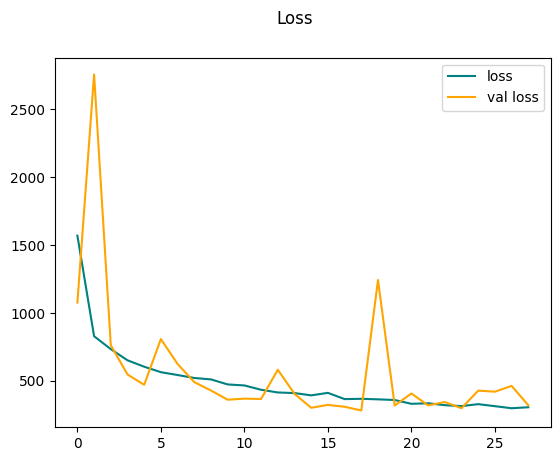

In [17]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

In [12]:
model.evaluate(test_dataset)

156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.9431 - loss: 296.5203 - mean_absolute_error: 6.9733


[330.4740905761719, 0.9418837428092957, 7.097593784332275]

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 


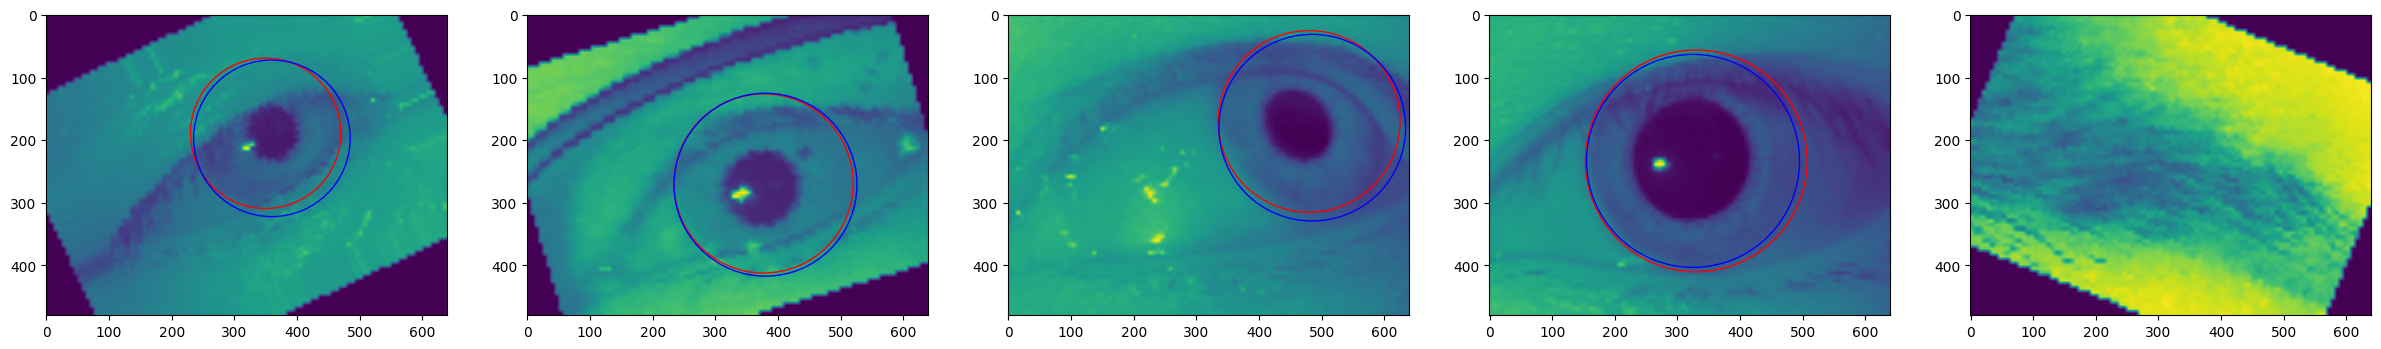

In [13]:
test = test_dataset.shuffle(5000).as_numpy_iterator().next()
pred = model.predict(test[0])

fig, ax = plt.subplots(ncols=5, figsize=(30,30))
for idx in range(5):
    image = np.copy(test[0][idx])
    iris_coords = test[1][idx]  
    pred_coords = pred[idx]
    
    image = cv2.resize(image, (initial_shape[1], initial_shape[0]))

    circle = plt.Circle((int(iris_coords[0]), int(iris_coords[1])), int(iris_coords[2]), color='r', fill=False)
    pred_circle = plt.Circle((int(pred_coords[0] * image.shape[0] / initial_shape[0]), int(pred_coords[1] * image.shape[1] / initial_shape[1])), int(pred_coords[2] * image.shape[0] / initial_shape[0]), color='b', fill=False)

    ax[idx].imshow(image)
    ax[idx].add_artist(circle)
    ax[idx].add_artist(pred_circle)

create a coordinate converter for other images

In [14]:
def predict_iris(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    original_shape = image.shape
    image = cv2.resize(image, (new_shape[1], new_shape[0]))   
    image = image / 255

    pred = model.predict(image.reshape(1, new_shape[0], new_shape[1], 1))
    return pred[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
[459.23914 276.0264  151.41508]


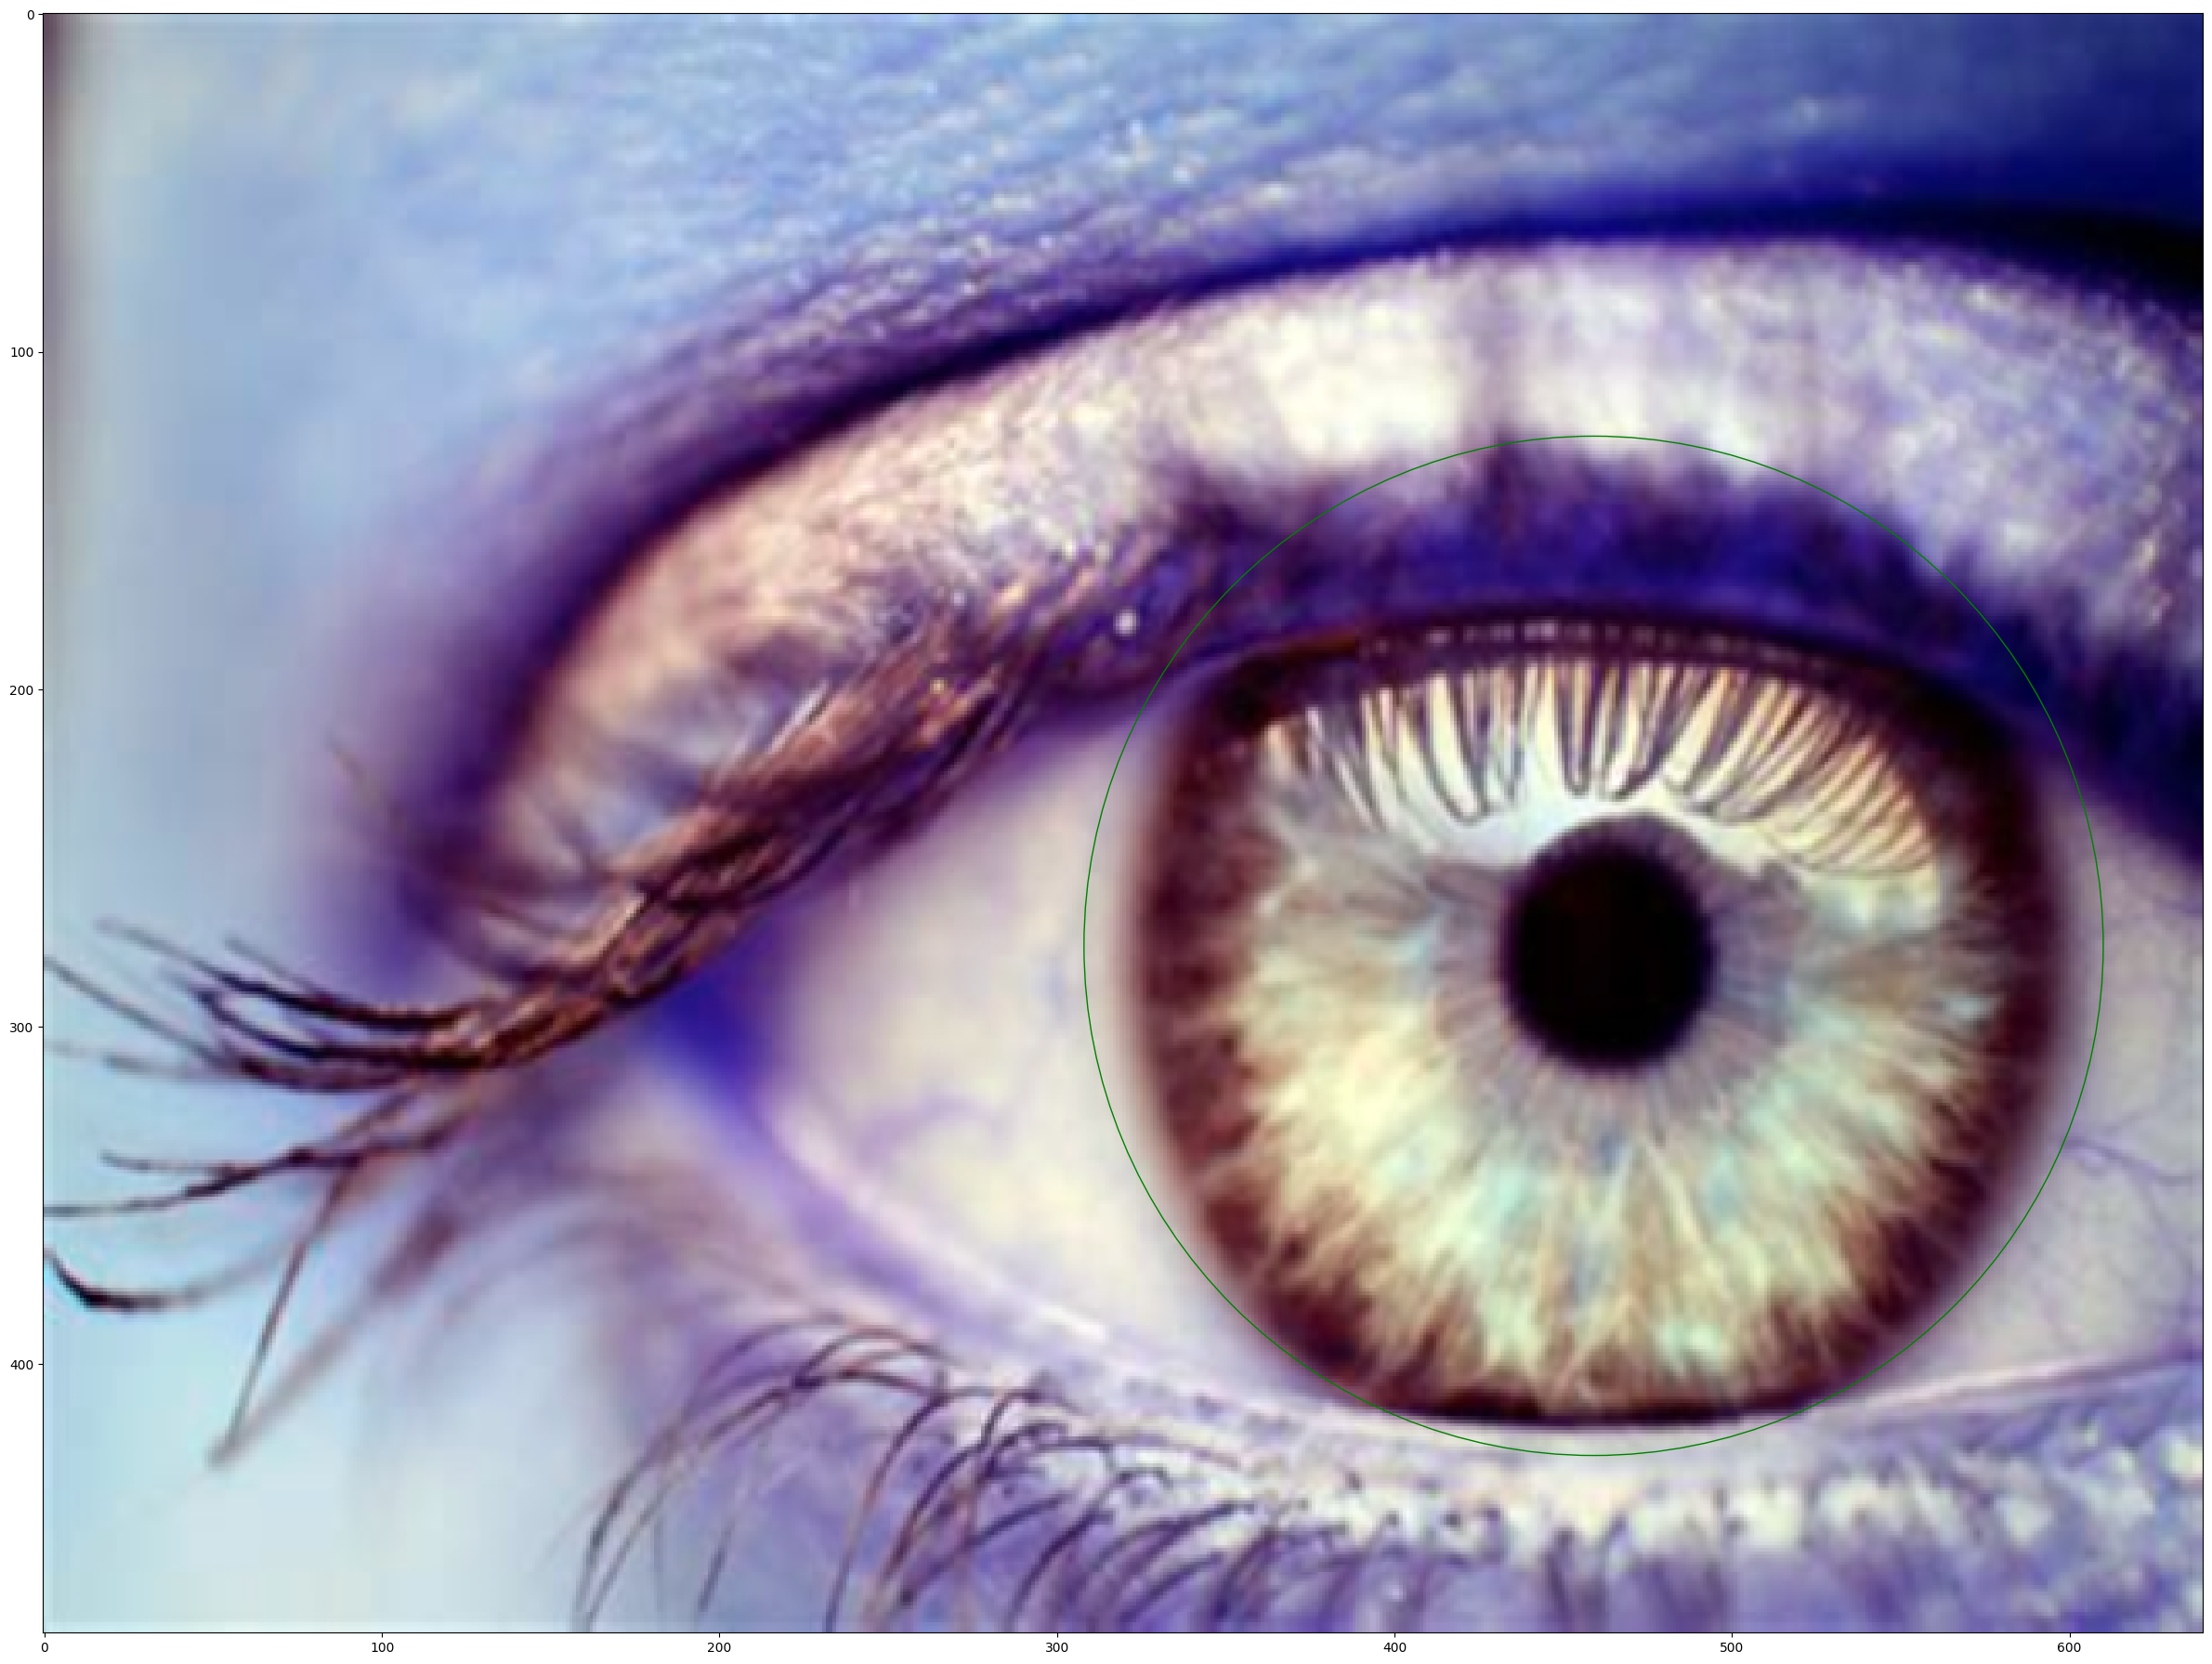

In [15]:
image_path = './dataset/test.jpg'
pred = predict_iris(image_path)
print(pred)

image = cv2.imread(image_path)
image = cv2.resize(image, (initial_shape[1], initial_shape[0]))
fig, ax = plt.subplots(figsize=(30,30))
circle = plt.Circle((int(pred[0]), int(pred[1])), int(pred[2]), color='g', fill=False)

ax.imshow(image)
ax.add_artist(circle)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[184.07388 235.40889 111.86438]


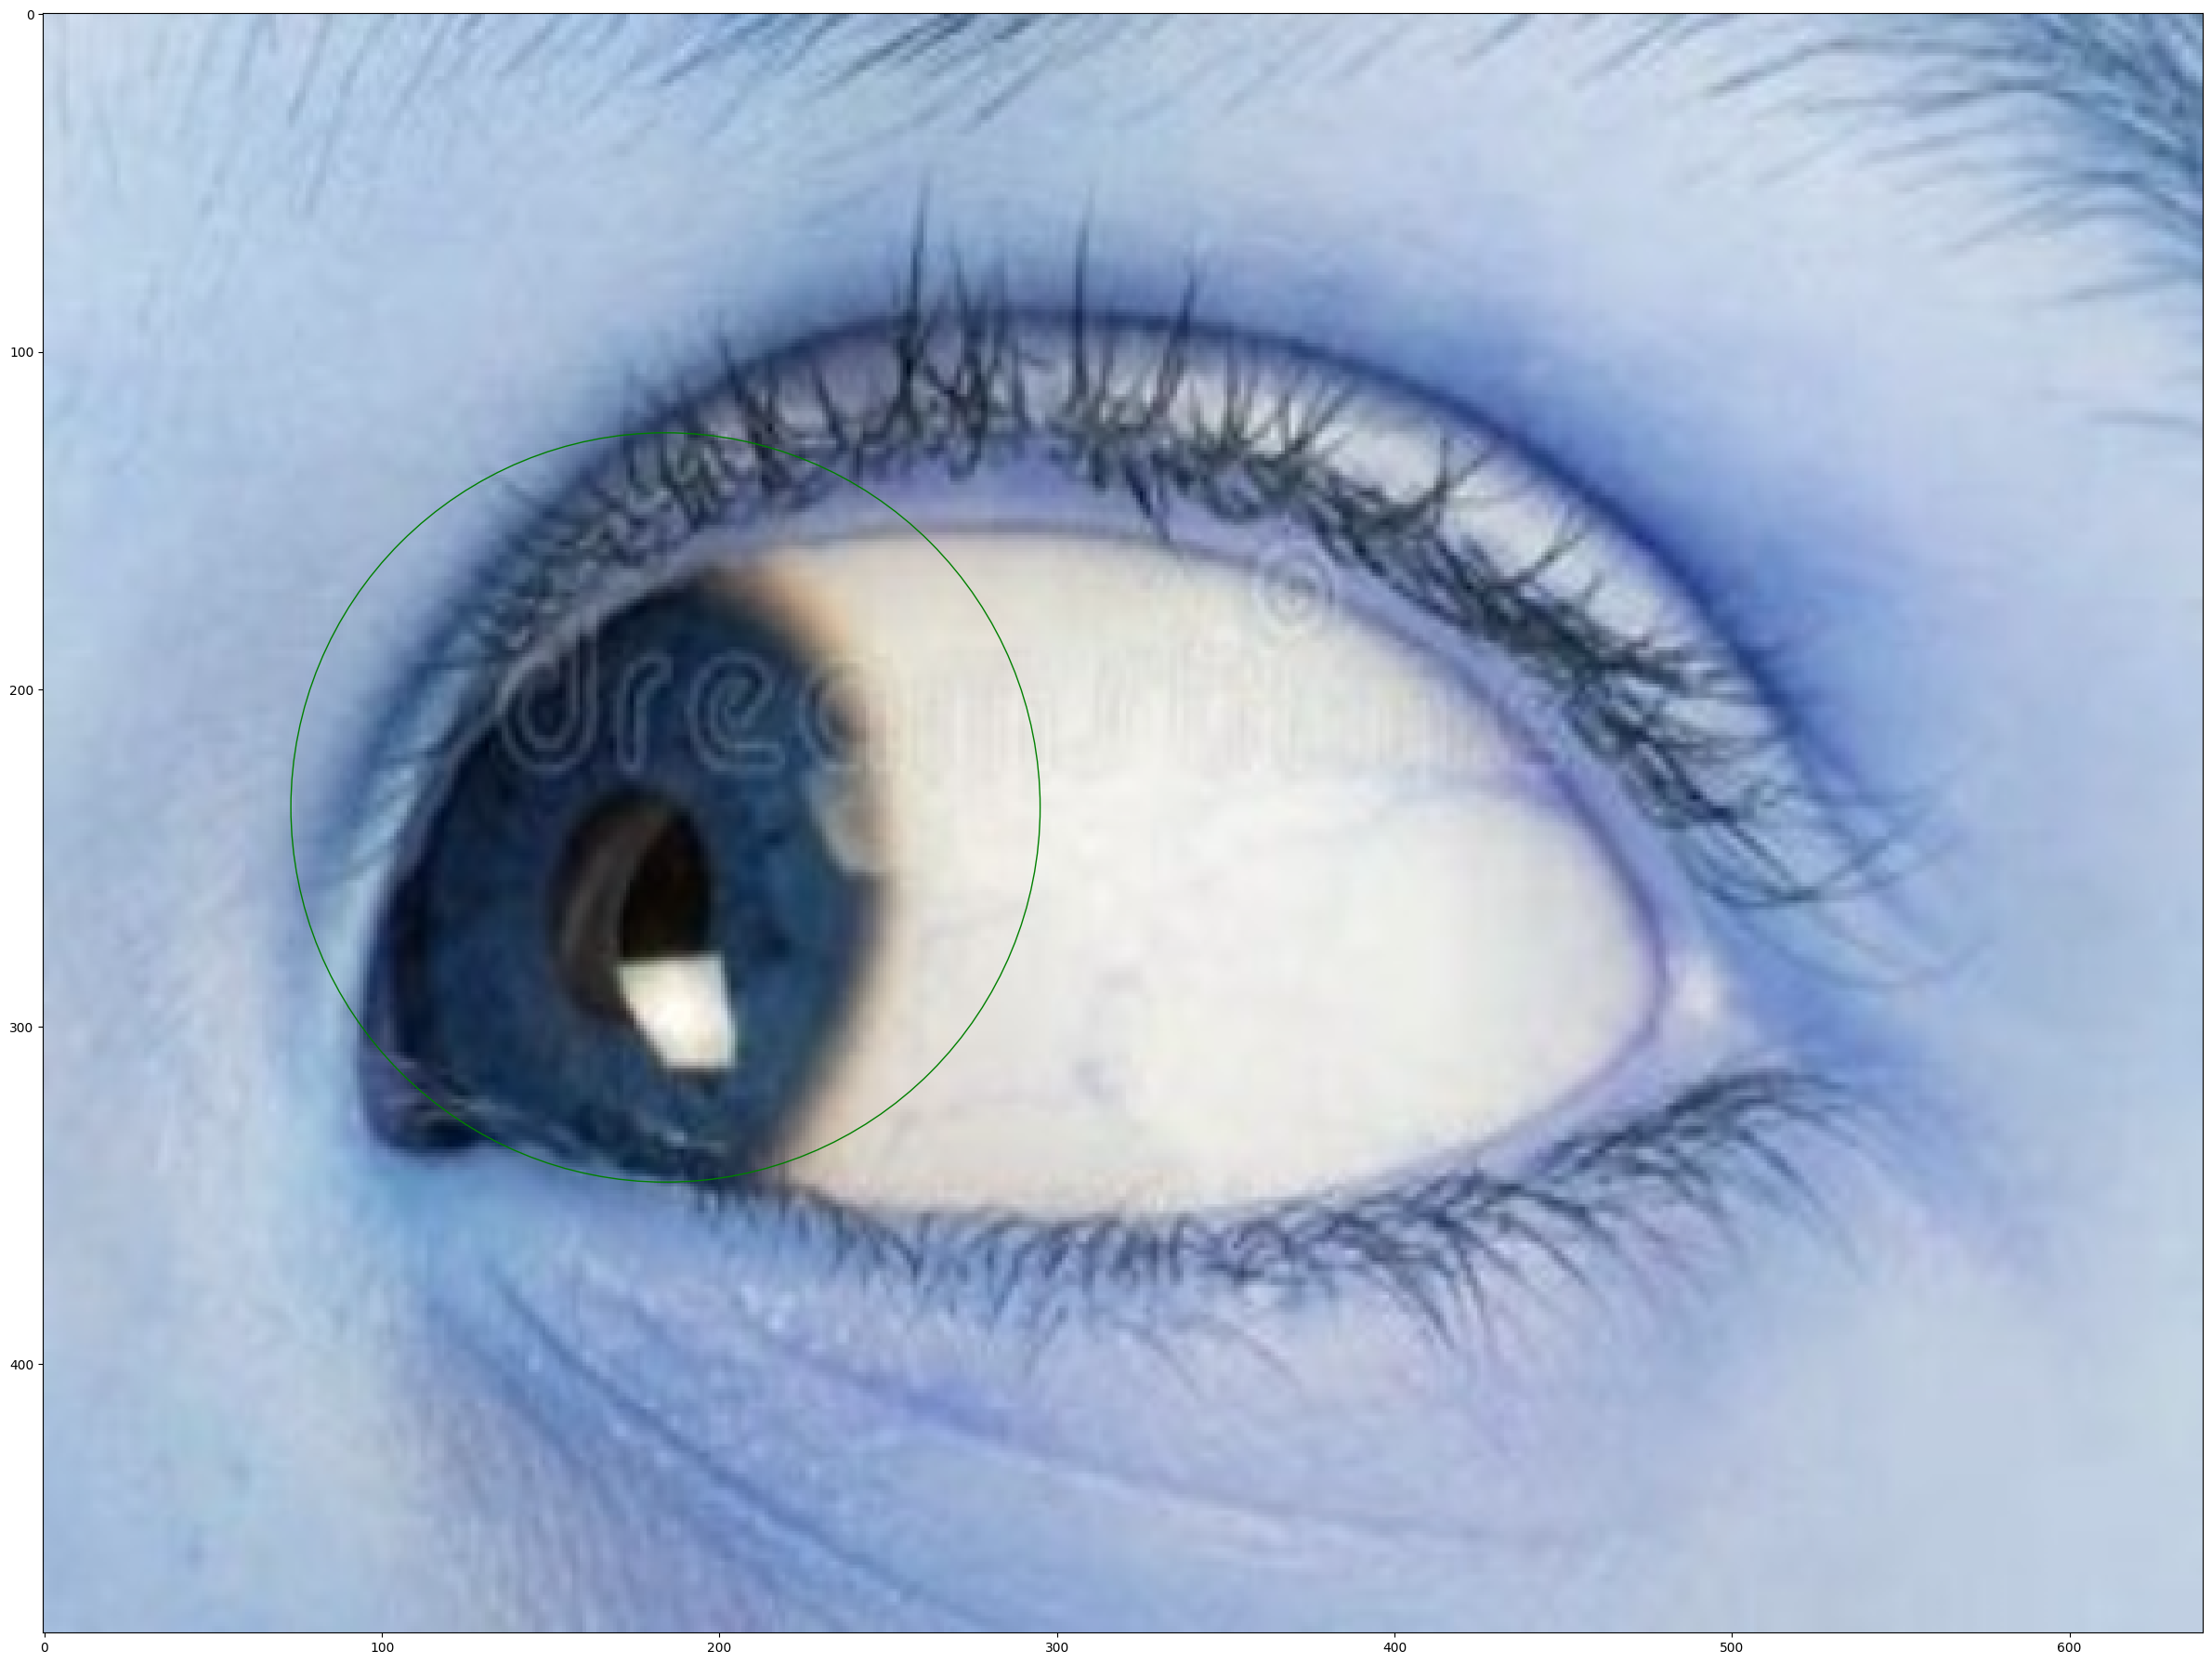

In [16]:
image_path = './dataset/test_2.jpg'
pred = predict_iris(image_path)
print(pred)

image = cv2.imread(image_path)
image = cv2.resize(image, (initial_shape[1], initial_shape[0]))
fig, ax = plt.subplots(figsize=(30,30))
circle = plt.Circle((int(pred[0]), int(pred[1])), int(pred[2]), color='g', fill=False)

ax.imshow(image)
ax.add_artist(circle)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[312.59863 217.11621 104.74391]


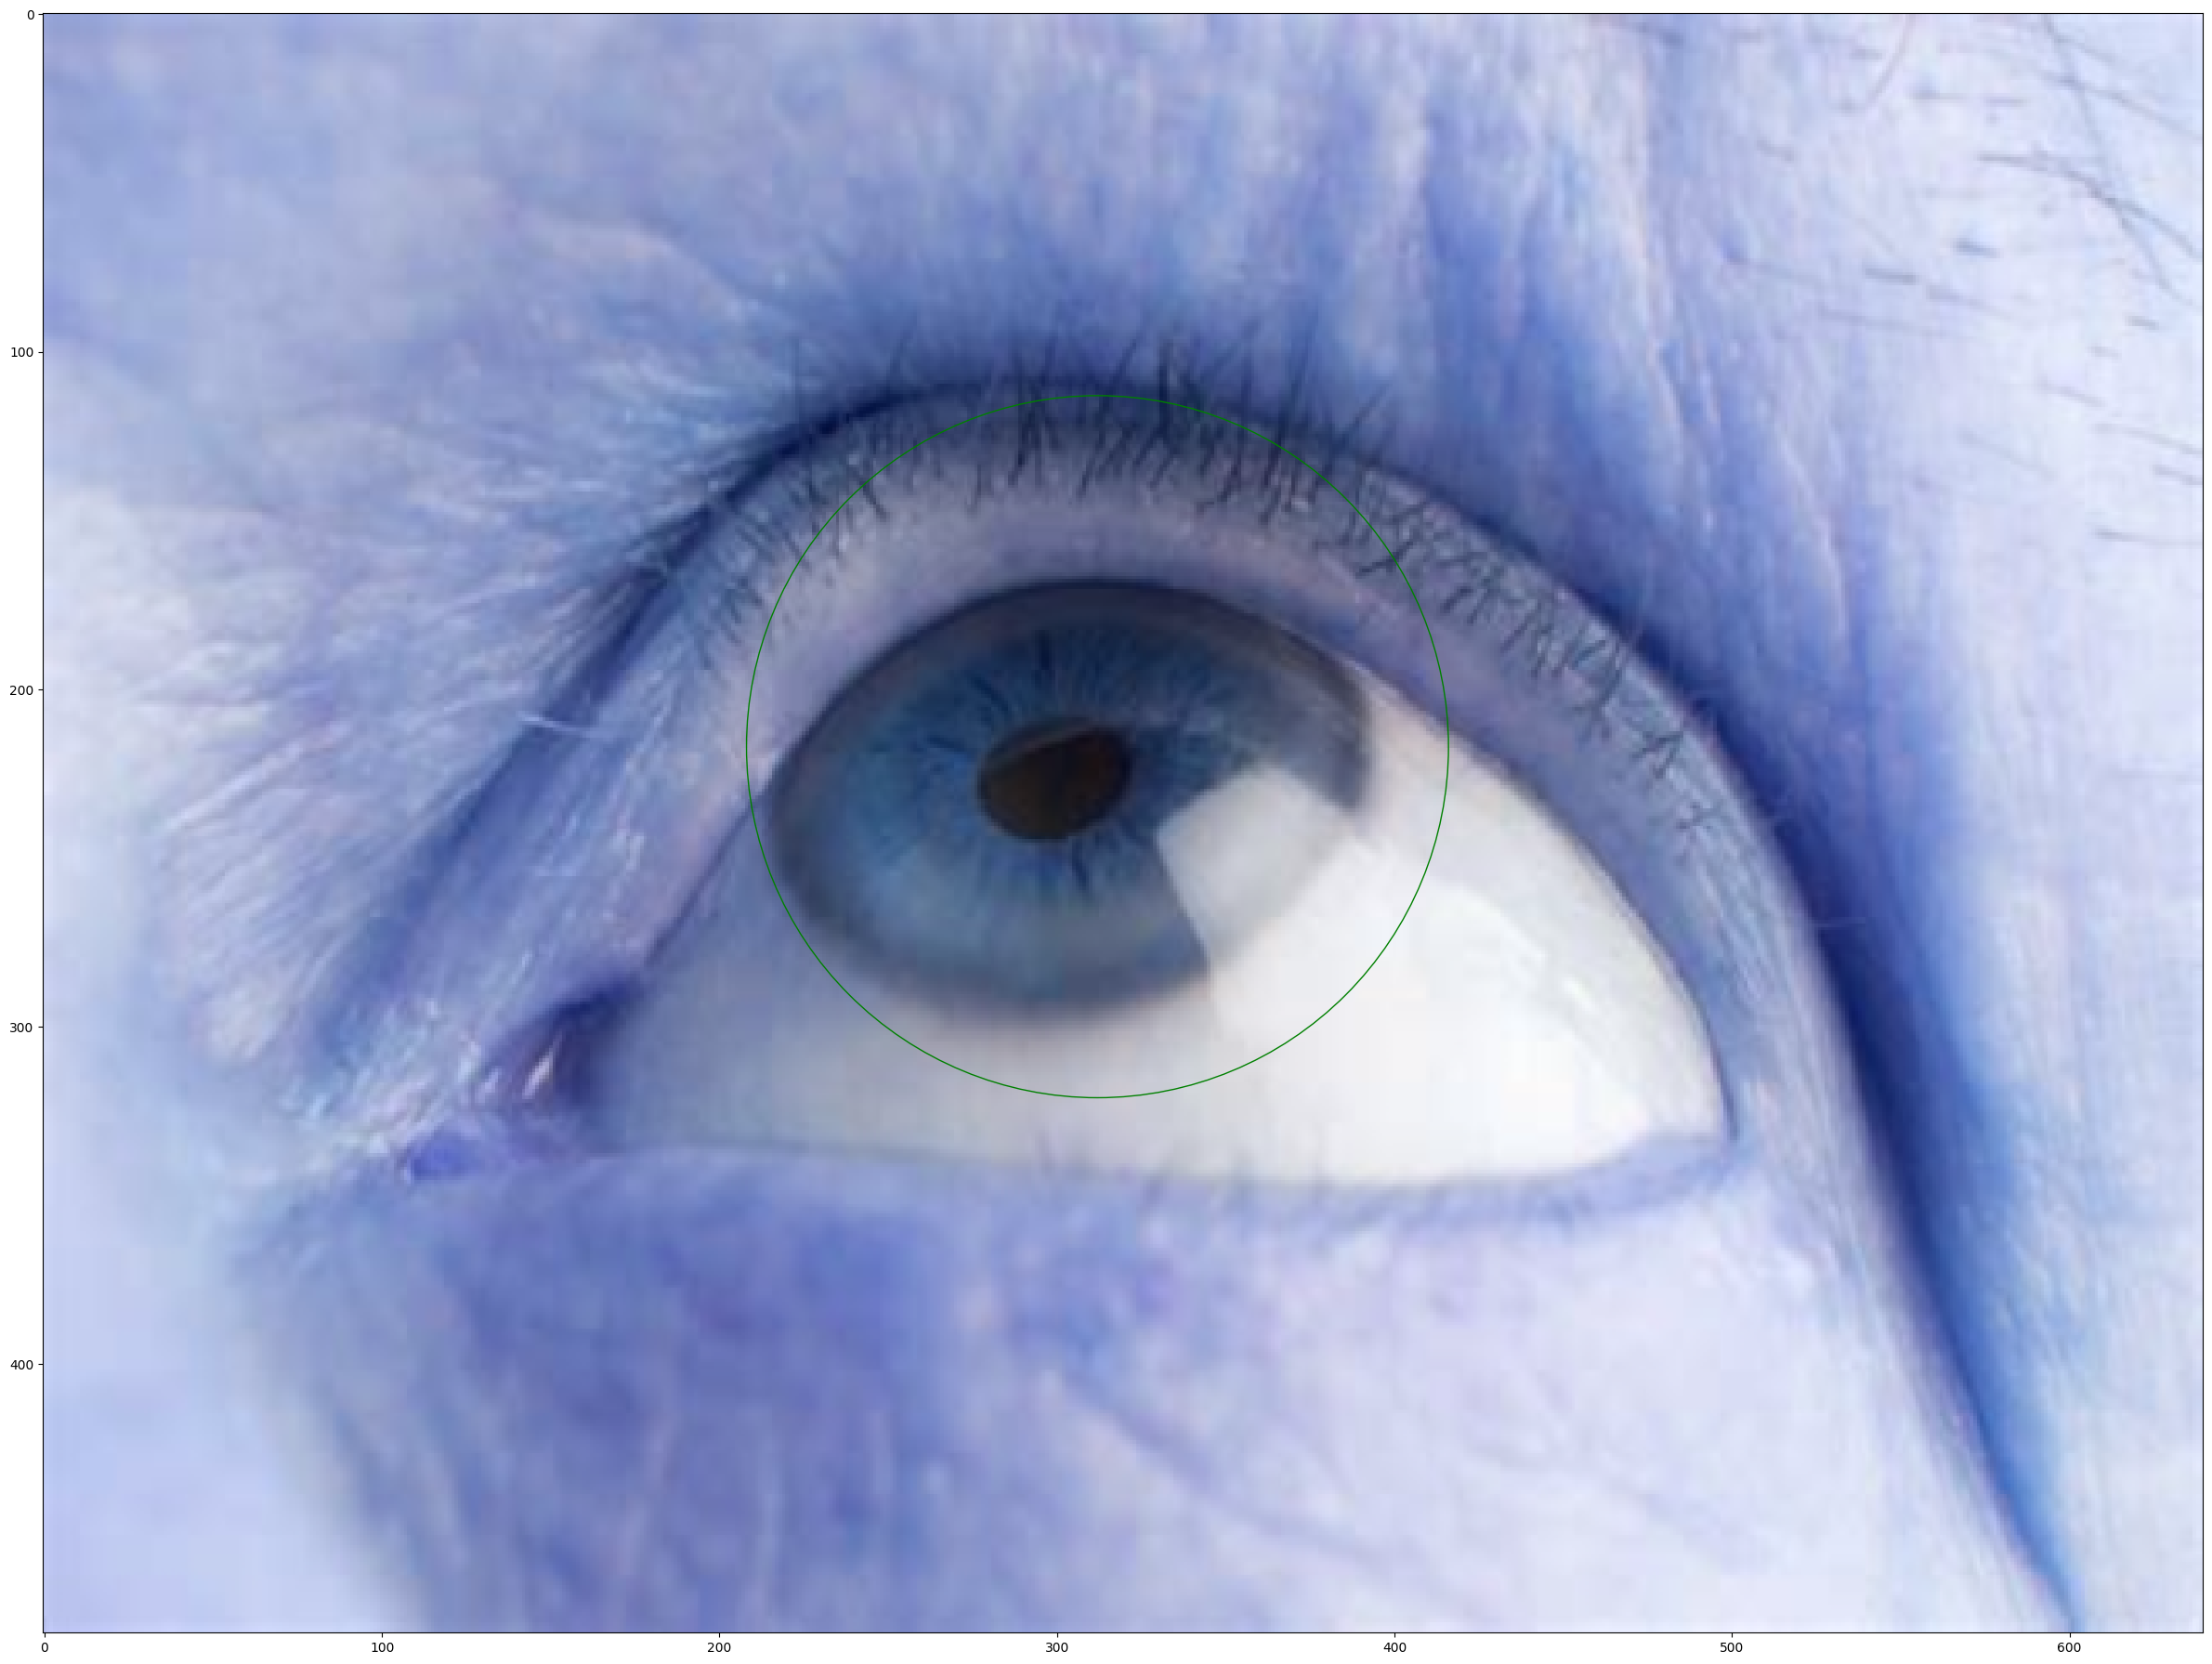

In [17]:
image_path = './dataset/test_3.jpg'

pred = predict_iris(image_path)
print(pred)

image = cv2.imread(image_path)
image = cv2.resize(image, (initial_shape[1], initial_shape[0]))

fig, ax = plt.subplots(figsize=(30,30))
circle = plt.Circle((int(pred[0]), int(pred[1])), int(pred[2]), color='g', fill=False)

ax.imshow(image)
ax.add_artist(circle)